<a href="https://colab.research.google.com/github/msrepo/ml-mscise-2023/blob/master/Edited_chapter08_intro_to_dl_for_computer_vision_i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision

## Introduction to convnets

**Instantiating a small convnet**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

**Training the convnet on MNIST images**

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 15s 5ms/step - loss: 0.1598 - accuracy: 0.9507
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0432 - accuracy: 0.9870
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0299 - accuracy: 0.9908
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0221 - accuracy: 0.9930
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0174 - accuracy: 0.9948


**Evaluating the convnet**

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0301 - accuracy: 0.9918
Test accuracy: 0.992


### The convolution operation

#### Understanding border effects and padding

#### Understanding convolution strides

### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [9]:
!git clone https://github.com/laxmimerit/dog-cat-full-dataset.git

Cloning into 'dog-cat-full-dataset'...
remote: Enumerating objects: 25027, done.
remote: Total 25027 (delta 0), reused 0 (delta 0), pack-reused 25027
Receiving objects: 100% (25027/25027), 541.62 MiB | 35.32 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (25001/25001), done.


**Copying images to training, validation, and test directories**

In [24]:
import os, shutil, pathlib

original_dir = pathlib.Path("/content/dog-cat-full-dataset/data/train")
new_base_dir = pathlib.Path("/content/cats_vs_dogs_small")
new_base_dir.mkdir(exist_ok=True)

def make_subset(subset_name, start_index, end_index):
    for category in ("cats", "dogs"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        subcategory_dir = original_dir/category
        images = sorted(subcategory_dir.glob('*.jpg'))
        for index,img in enumerate(images[start_index:end_index]):
            shutil.copyfile(src=img,
                            dst=dir / img.name)


make_subset("train", start_index=1, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)
for category in ['train','validation','test']:
  print(category,len(list((new_base_dir/category).rglob('*.jpg'))))

train 1998
validation 1000
test 2000


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [26]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

**Configuring the model for training**

In [27]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [28]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 1998 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [29]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [30]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [31]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [32]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [33]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 8s 74ms/step - loss: 0.7090 - accuracy: 0.4925 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6939 - accuracy: 0.5370 - val_loss: 0.6901 - val_accuracy: 0.5440
Epoch 3/30
63/63 [==============================] - 5s 64ms/step - loss: 0.6855 - accuracy: 0.5771 - val_loss: 0.6695 - val_accuracy: 0.6020
Epoch 4/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6655 - accuracy: 0.6171 - val_loss: 0.6342 - val_accuracy: 0.6390
Epoch 5/30
63/63 [==============================] - 5s 76ms/step - loss: 0.6260 - accuracy: 0.6386 - val_loss: 0.6498 - val_accuracy: 0.6410
Epoch 6/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6164 - accuracy: 0.6697 - val_loss: 0.6213 - val_accuracy: 0.6700
Epoch 7/30
63/63 [==============================] - 4s 63ms/step - loss: 0.5734 - accuracy: 0.6962 - val_loss: 0.6330 - val_accuracy: 0.6630
Epoch 8/30
63

**Displaying curves of loss and accuracy during training**

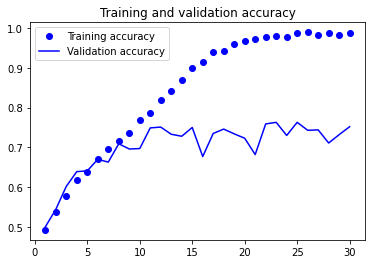

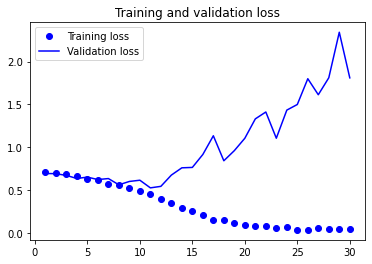

In [35]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [36]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 47ms/step - loss: 0.5281 - accuracy: 0.7430
Test accuracy: 0.743


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [37]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

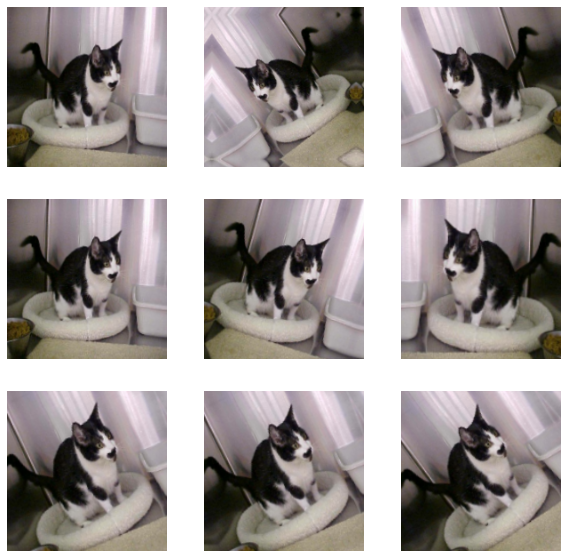

In [38]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [39]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100


63/63 [==============================] - 20s 219ms/step - loss: 0.6974 - accuracy: 0.5070 - val_loss: 0.6924 - val_accuracy: 0.5080
Epoch 2/100
63/63 [==============================] - 14s 211ms/step - loss: 0.6917 - accuracy: 0.5200 - val_loss: 0.8503 - val_accuracy: 0.5030
Epoch 3/100
63/63 [==============================] - 14s 216ms/step - loss: 0.6796 - accuracy: 0.5746 - val_loss: 0.6684 - val_accuracy: 0.6110
Epoch 4/100
63/63 [==============================] - 14s 212ms/step - loss: 0.6689 - accuracy: 0.5981 - val_loss: 0.6671 - val_accuracy: 0.6200
Epoch 5/100
63/63 [==============================] - 15s 231ms/step - loss: 0.6649 - accuracy: 0.6156 - val_loss: 0.6610 - val_accuracy: 0.5740
Epoch 6/100
63/63 [==============================] - 14s 212ms/step - loss: 0.6485 - accuracy: 0.6196 - val_loss: 0.6278 - val_accuracy: 0.6440
Epoch 7/100
63/63 [==============================] - 14s 217ms/step - loss: 0.6345 - accuracy: 0.6391 - val_loss: 0.6051 - val_accuracy: 0.6990
Epoc

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

**Plotting the results**

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

### Fine-tuning a pretrained model

In [ ]:
conv_base.summary()

**Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

## Summary